In [2]:
import pandas as pd
from pathlib import Path 
from fastai.vision import *
from fastai.metrics import AUROC
%matplotlib inline

# Data locations
path = Path("data/")

## Collect data

In [3]:
df = pd.read_csv(path/"train.csv")
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [15]:
tfms = get_transforms(flip_vert=True)

In [27]:
test = ImageList.from_csv(path, folder="test", csv_name="sample_submission.csv")
train = (ImageList.from_csv(path, folder="train", csv_name="train.csv")
    .split_by_rand_pct(0.01)
    .label_from_df()
    .add_test(test)
    .transform(tfms, size=128)
    .databunch(path=".", bs=64)
    .normalize(imagenet_stats)
        )

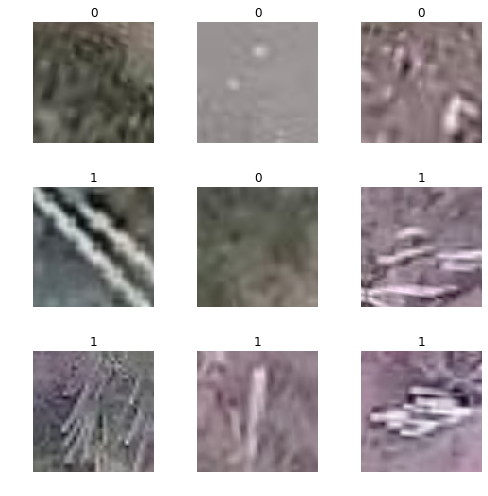

In [28]:
train.show_batch(rows=3, figsize=(7, 7))

## Train learner

In [29]:
# Using AUROC() works, but auc_roc_curve directly not?
# --> See https://github.com/fastai/fastai/issues/1939
learn = cnn_learner(train, models.resnet50, metrics=AUROC())

In [30]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [31]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,auroc,time
0,0.083021,0.010845,1.000000,00:54
1,0.044967,0.010155,1.000000,00:54
2,0.028078,0.004052,1.000000,00:54
3,0.024272,0.003433,1.000000,00:54


In [32]:
learn.save("stage-final")

## Visualize

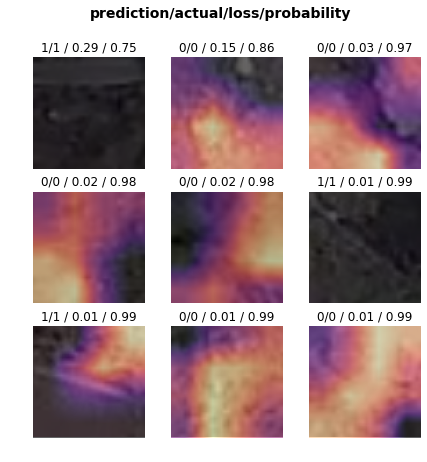

In [33]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(7, 7))

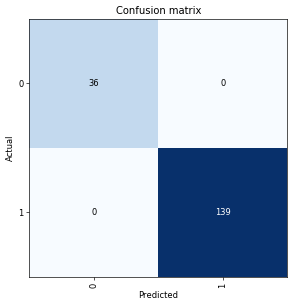

In [34]:
interp.plot_confusion_matrix(figsize=(5, 5), dpi=60)

## Create test predictions

In [35]:
preds, targs = learn.get_preds(ds_type=DatasetType.Test)

In [37]:
submission = pd.read_csv(path/"sample_submission.csv")
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.5
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.5
2,001ee6d8564003107853118ab87df407.jpg,0.5
3,002e175c3c1e060769475f52182583d0.jpg,0.5
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.5


In [57]:
submission["has_cactus"] = preds.clone().detach().numpy().argmax(1)

In [58]:
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1
1,0017242f54ececa4512b4d7937d1e21e.jpg,1
2,001ee6d8564003107853118ab87df407.jpg,0
3,002e175c3c1e060769475f52182583d0.jpg,0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,1


In [61]:
submission.to_csv("submission.csv", index=False)

In [63]:
!kaggle competitions submit -f submission.csv -m "First submission" aerial-cactus-identification

100%|████████████████████████████████████████| 152k/152k [00:04<00:00, 33.6kB/s]
403 - This competition only allows kernel submissions.


## Unnecessary

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.057361,0.022006,0.006571,00:17


In [31]:
learn.load("stage-1");

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


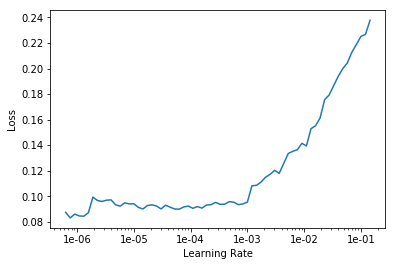

In [33]:
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.075495,0.047298,0.016857,00:17
1,0.063691,0.028438,0.010857,00:17
2,0.044034,0.028003,0.011143,00:17
